In [13]:
#Import necessary libs
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns #For heatmap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing

from preprocessing.preprocess_data import DataSet
import catboost as cb
%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [14]:
# selected_features = ['date_forecast', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
#        'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
#        'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
#        'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
#        'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
#        'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
#        'fresh_snow_6h:cm', 'is_in_shadow:idx',
#        'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
#        'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
#        'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
#        'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
#        'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
#        'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
#        'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
#        'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms']

# selected_features = ['date_forecast', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
#        'clear_sky_energy_1h:J', 'clear_sky_rad:W',
#        'dew_point_2m:K',
#        'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
#        'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
#        'is_in_shadow:idx',
#        'msl_pressure:hPa', 'precip_5min:mm',
#        'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
#        'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
#        'snow_depth:cm', 'snow_drift:idx',
#        'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
#        'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
#        'total_cloud_cover:p', 'visibility:m', 
#        'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms']

selected_features = ['date_forecast', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'is_in_shadow:idx', 'is_day:idx',
       'msl_pressure:hPa', 'precip_5min:mm',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
       'total_cloud_cover:p', 'visibility:m', 
       'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms']


made_features = ['location', 'is_in_shadow:idx']

drop_feature = 'diffuse_rad:W'


In [15]:
data_collection = DataSet()
data_collection.select_features(selected_features)
data_collection.resample_to_hourly()
data_collection.remove_nans(drop_feature)
data_collection.combine_obs_est()

In [16]:

def scale(series, feature_name):
    scaler = preprocessing.MinMaxScaler()
    series1 = pd.DataFrame({feature_name:series})
    series1[feature_name] = scaler.fit_transform(series1[[feature_name]])
    return series1


In [17]:
feature_name = 'absolute_humidity_2m:gm3'
a_s = data_collection.X_test_estimated['a'].set_index('date_forecast')[feature_name]
scale(a_s, feature_name)

,absolute_humidity_2m:gm3
date_forecast,
2023-05-01 00:00:00,0.107399
2023-05-01 01:00:00,0.102625
2023-05-01 02:00:00,0.090692
2023-05-01 03:00:00,0.078759
2023-05-01 04:00:00,0.066826
...,...
2023-07-03 19:00:00,0.491647
2023-07-03 20:00:00,0.508353
2023-07-03 21:00:00,0.536993


From plot below we see that data where diff_rad is zero for long periods of time, the other data is linearly interpolated. Just how the plotting operates.

<Axes: title={'center': 'X test c'}, xlabel='date_forecast'>

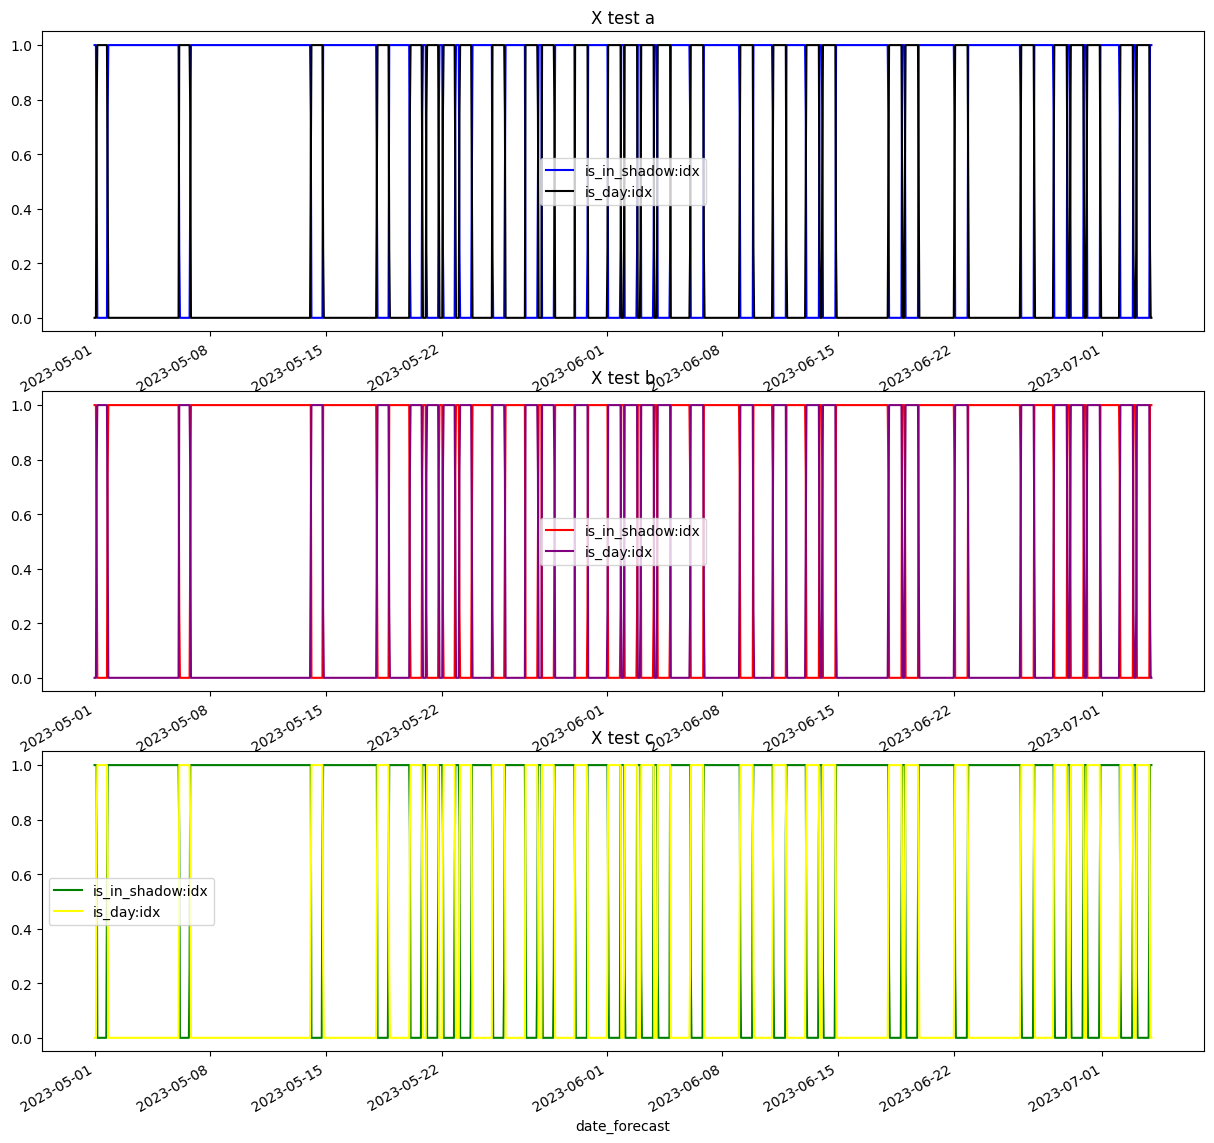

In [18]:
feature_name = 'is_in_shadow:idx'
# feature_name2 = 'diffuse_rad:W'
feature_name2 = 'is_day:idx'

fig, axs = plt.subplots(3,1,figsize = (15,15))
scale(data_collection.X_test_estimated['a'].set_index('date_forecast')[feature_name], feature_name).plot(ax=axs[0], title='X test a', color='blue')
scale(data_collection.X_test_estimated['b'].set_index('date_forecast')[feature_name], feature_name).plot(ax=axs[1], title='X test b', color='red')
scale(data_collection.X_test_estimated['c'].set_index('date_forecast')[feature_name], feature_name).plot(ax=axs[2], title='X test c', color='green')
scale(data_collection.X_test_estimated['a'].set_index('date_forecast')[feature_name2], feature_name2).plot(ax=axs[0], title='X test a', color='black')
scale(data_collection.X_test_estimated['b'].set_index('date_forecast')[feature_name2], feature_name2).plot(ax=axs[1], title='X test b', color='purple')
scale(data_collection.X_test_estimated['c'].set_index('date_forecast')[feature_name2], feature_name2).plot(ax=axs[2], title='X test c', color='yellow')

<Axes: xlabel='date_forecast', ylabel='is_in_shadow:idx'>

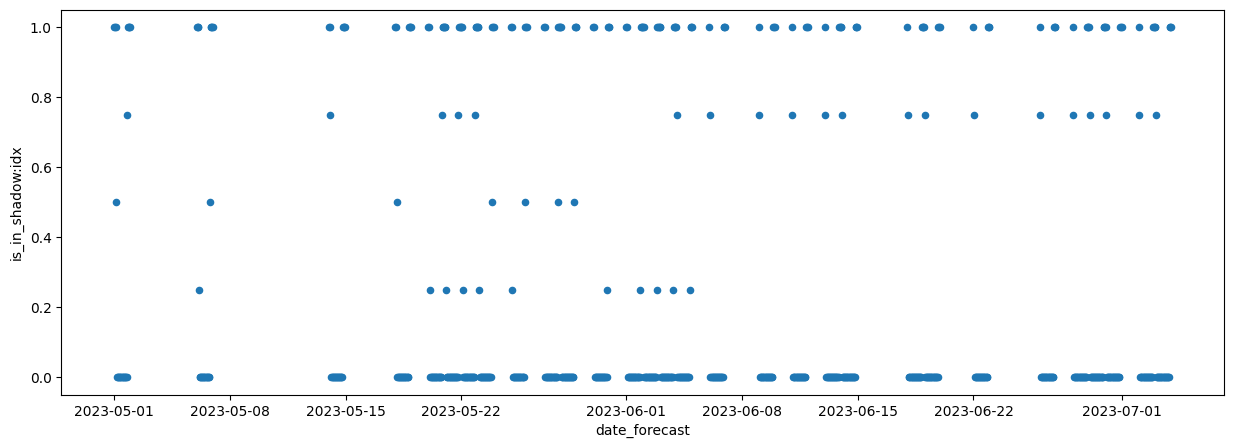

In [19]:
data_collection.X_test_estimated['a'].plot(x = 'date_forecast', y = feature_name, kind = 'scatter', figsize= (15,5))

<Axes: title={'center': 'C'}, xlabel='time'>

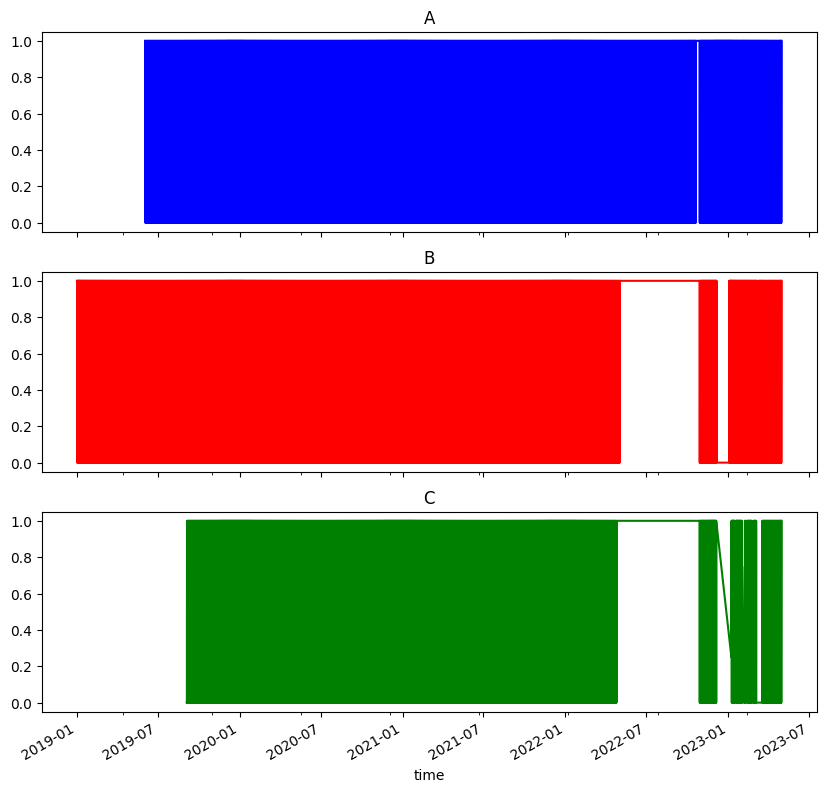

In [20]:
#
# data_collection.X_train_estimated['a'].plot(x = 'date_forecast', y = feature_name, kind = 'line', figsize=(15,5))
# data_collection.X_train_observed['a'].plot(x = 'date_forecast', y = feature_name, kind = 'line', figsize=(15,5))
fig, axs = plt.subplots(3,1,figsize = (10,10), sharex=True)
data_collection.X_train['a'].set_index('time')[feature_name].plot(ax= axs[0], title='A', color ='blue')
data_collection.X_train['b'].set_index('time')[feature_name].plot(ax= axs[1], title='B', color ='red')
data_collection.X_train['c'].set_index('time')[feature_name].plot(ax= axs[2], title='C', color ='green')






## Investigation of distributional difference of A, B, and C on observed data.

<Axes: title={'center': '2023'}, xlabel='date_forecast'>

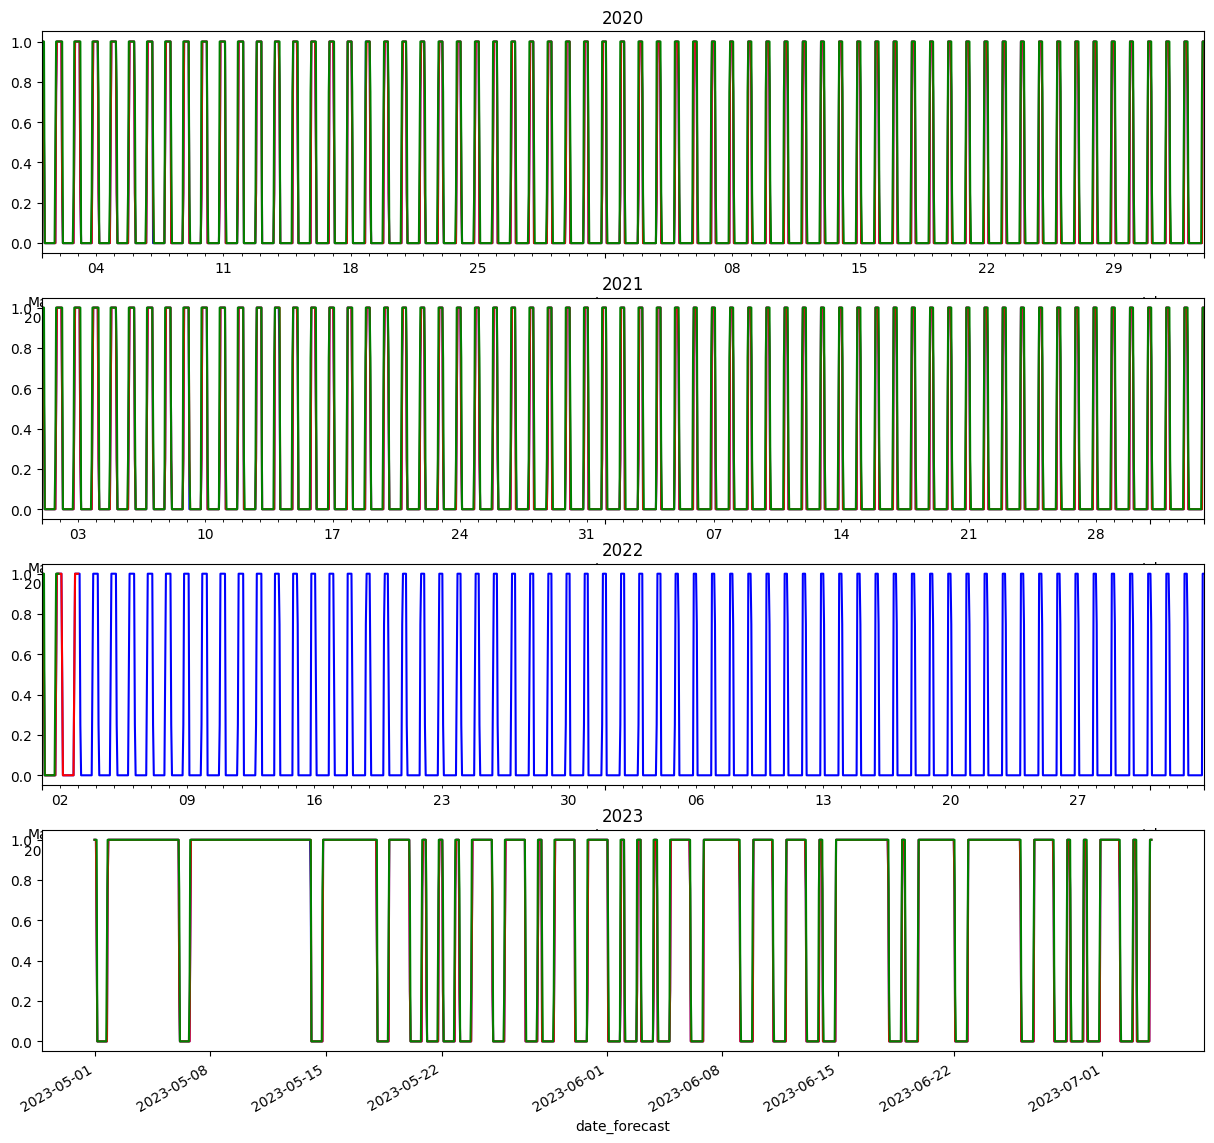

In [21]:

fig, axs = plt.subplots(4,1,figsize = (15,15))
data_collection.X_train_observed['a'].set_index('date_forecast')[feature_name]['2020-05-01':'2020-07-03'].plot(ax= axs[0], title='2020', color = 'blue')
data_collection.X_train_observed['b'].set_index('date_forecast')[feature_name]['2020-05-01':'2020-07-03'].plot(ax= axs[0], title='2020', color ='red')
data_collection.X_train_observed['c'].set_index('date_forecast')[feature_name]['2020-05-01':'2020-07-03'].plot(ax= axs[0], title='2020', color ='green')

data_collection.X_train_observed['a'].set_index('date_forecast')[feature_name]['2021-05-01':'2021-07-03'].plot(ax= axs[1], title='2021', color = 'blue')
data_collection.X_train_observed['b'].set_index('date_forecast')[feature_name]['2021-05-01':'2021-07-03'].plot(ax= axs[1], title='2021', color ='red')
data_collection.X_train_observed['c'].set_index('date_forecast')[feature_name]['2021-05-01':'2021-07-03'].plot(ax= axs[1], title='2021', color ='green')

data_collection.X_train_observed['a'].set_index('date_forecast')[feature_name]['2022-05-01':'2022-07-03'].plot(ax= axs[2], title='2022', color = 'blue')
data_collection.X_train_observed['b'].set_index('date_forecast')[feature_name]['2022-05-01':'2022-07-03'].plot(ax= axs[2], title='2022', color ='red')
data_collection.X_train_observed['c'].set_index('date_forecast')[feature_name]['2022-05-01':'2022-07-03'].plot(ax= axs[2], title='2022', color ='green')

data_collection.X_test_estimated['a'].set_index('date_forecast')[feature_name]['2023-05-01':'2023-07-03'].plot(ax= axs[3], title='2023', color = 'blue')
data_collection.X_test_estimated['b'].set_index('date_forecast')[feature_name]['2023-05-01':'2023-07-03'].plot(ax= axs[3], title='2023', color ='red')
data_collection.X_test_estimated['c'].set_index('date_forecast')[feature_name]['2023-05-01':'2023-07-03'].plot(ax= axs[3], title='2023', color ='green')


### Trying to extract all unique dates in X_test

In [22]:
a = data_collection.X_test_estimated['a']

test_days = pd.to_datetime(a['date_forecast']).dt.normalize().unique()
len(test_days)

30

In [23]:
# test_days[0].date()
# success!
a[(a['date_forecast'] > test_days[0]) & (a['date_forecast'] <= test_days[1])].shape

(24, 34)

## Calculating distributional difference between a, b and c in a given period 

In [26]:
features = data_collection.X_train_observed['a'].columns
a_obs = data_collection.X_train_observed['a'].set_index('date_forecast')['2020-05-01':'2021-07-03']
b_obs = data_collection.X_train_observed['b'].set_index('date_forecast')['2020-05-01':'2021-07-03']
c_obs = data_collection.X_train_observed['c'].set_index('date_forecast')['2020-05-01':'2021-07-03']

a_test = data_collection.X_test_estimated['a'].set_index('date_forecast')
b_test = data_collection.X_test_estimated['b'].set_index('date_forecast')
c_test = data_collection.X_test_estimated['c'].set_index('date_forecast')

# mean_absolute_error(scale(a_obs[feature_name], feature_name), scale(b_obs[feature_name], feature_name))

# categorical = ['date_forecast', 'dew_or_rime:idx', 'is_day:idx', 'is_in_shadow:idx', 'snow_drift:idx']

categorical = ['date_forecast']
for f in features:
    if f not in categorical:
        mae_ab = mean_absolute_error(scale(a_test[f], f), scale(b_test[f], f))
        mae_ac = mean_absolute_error(scale(a_test[f], f), scale(c_test[f], f))
        mae_cb = mean_absolute_error(scale(c_test[f], f), scale(b_test[f], f))
        # mae_ab = mean_absolute_error(a_test[f], b_test[f])
        # mae_ac = mean_absolute_error(a_test[f], c_test[f])
        # mae_cb = mean_absolute_error(c_test[f], b_test[f])

        # if mae_ab > 0.1:
        print(f"MAE of feature {f} between a and b:{mae_ab:.4f}")
        print(f"MAE of feature {f} between a and c:{mae_ac:.4f}")
        print(f"MAE of feature {f} between c and b:{mae_cb:.4f}")
        print('----------------------------------')


MAE of feature absolute_humidity_2m:gm3 between a and b:0.0020
MAE of feature absolute_humidity_2m:gm3 between a and c:0.0496
MAE of feature absolute_humidity_2m:gm3 between c and b:0.0490
----------------------------------
MAE of feature air_density_2m:kgm3 between a and b:0.0156
MAE of feature air_density_2m:kgm3 between a and c:0.0110
MAE of feature air_density_2m:kgm3 between c and b:0.0222
----------------------------------
MAE of feature clear_sky_energy_1h:J between a and b:0.0000
MAE of feature clear_sky_energy_1h:J between a and c:0.0002
MAE of feature clear_sky_energy_1h:J between c and b:0.0002
----------------------------------
MAE of feature clear_sky_rad:W between a and b:0.0000
MAE of feature clear_sky_rad:W between a and c:0.0002
MAE of feature clear_sky_rad:W between c and b:0.0002
----------------------------------
MAE of feature dew_point_2m:K between a and b:0.0015
MAE of feature dew_point_2m:K between a and c:0.0460
MAE of feature dew_point_2m:K between c and b:0.0